In [1]:
# Import all necessary libraries

from astropy.io import fits

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
sns.set()

from astropy.stats import sigma_clipped_stats
from astropy.convolution import convolve, Box1DKernel

# Import lightcurves

lc1 = fits.open('ch2_xsm_20210923_v1_level2.lc')
lc2 = fits.open('ch2_xsm_20210924_v1_level2.lc')
lc3 = fits.open('ch2_xsm_20210927_v1_level2.lc')
lc4 = fits.open('ch2_xsm_20210928_v1_level2.lc')
lc5 = fits.open('ch2_xsm_20210929_v1_level2.lc')
lc_arr = [lc1, lc2, lc3, lc4, lc5]

# Part 1
Smoothening a light curve

#### 1.2) Implement a box car average over the lightcurves

In [2]:
# Get timestamps and count-rates for all files
time_lc = [x[1].data["TIME"] for x in lc_arr]
rates_lc = [x[1].data["RATE"] for x in lc_arr]

# Implement boxcar averaging
width = 10
rates_smooth = [convolve(r, Box1DKernel(width)) for r in rates_lc]

#### 1.3) Overplot the original and smoothed lightcurve and notice the difference.

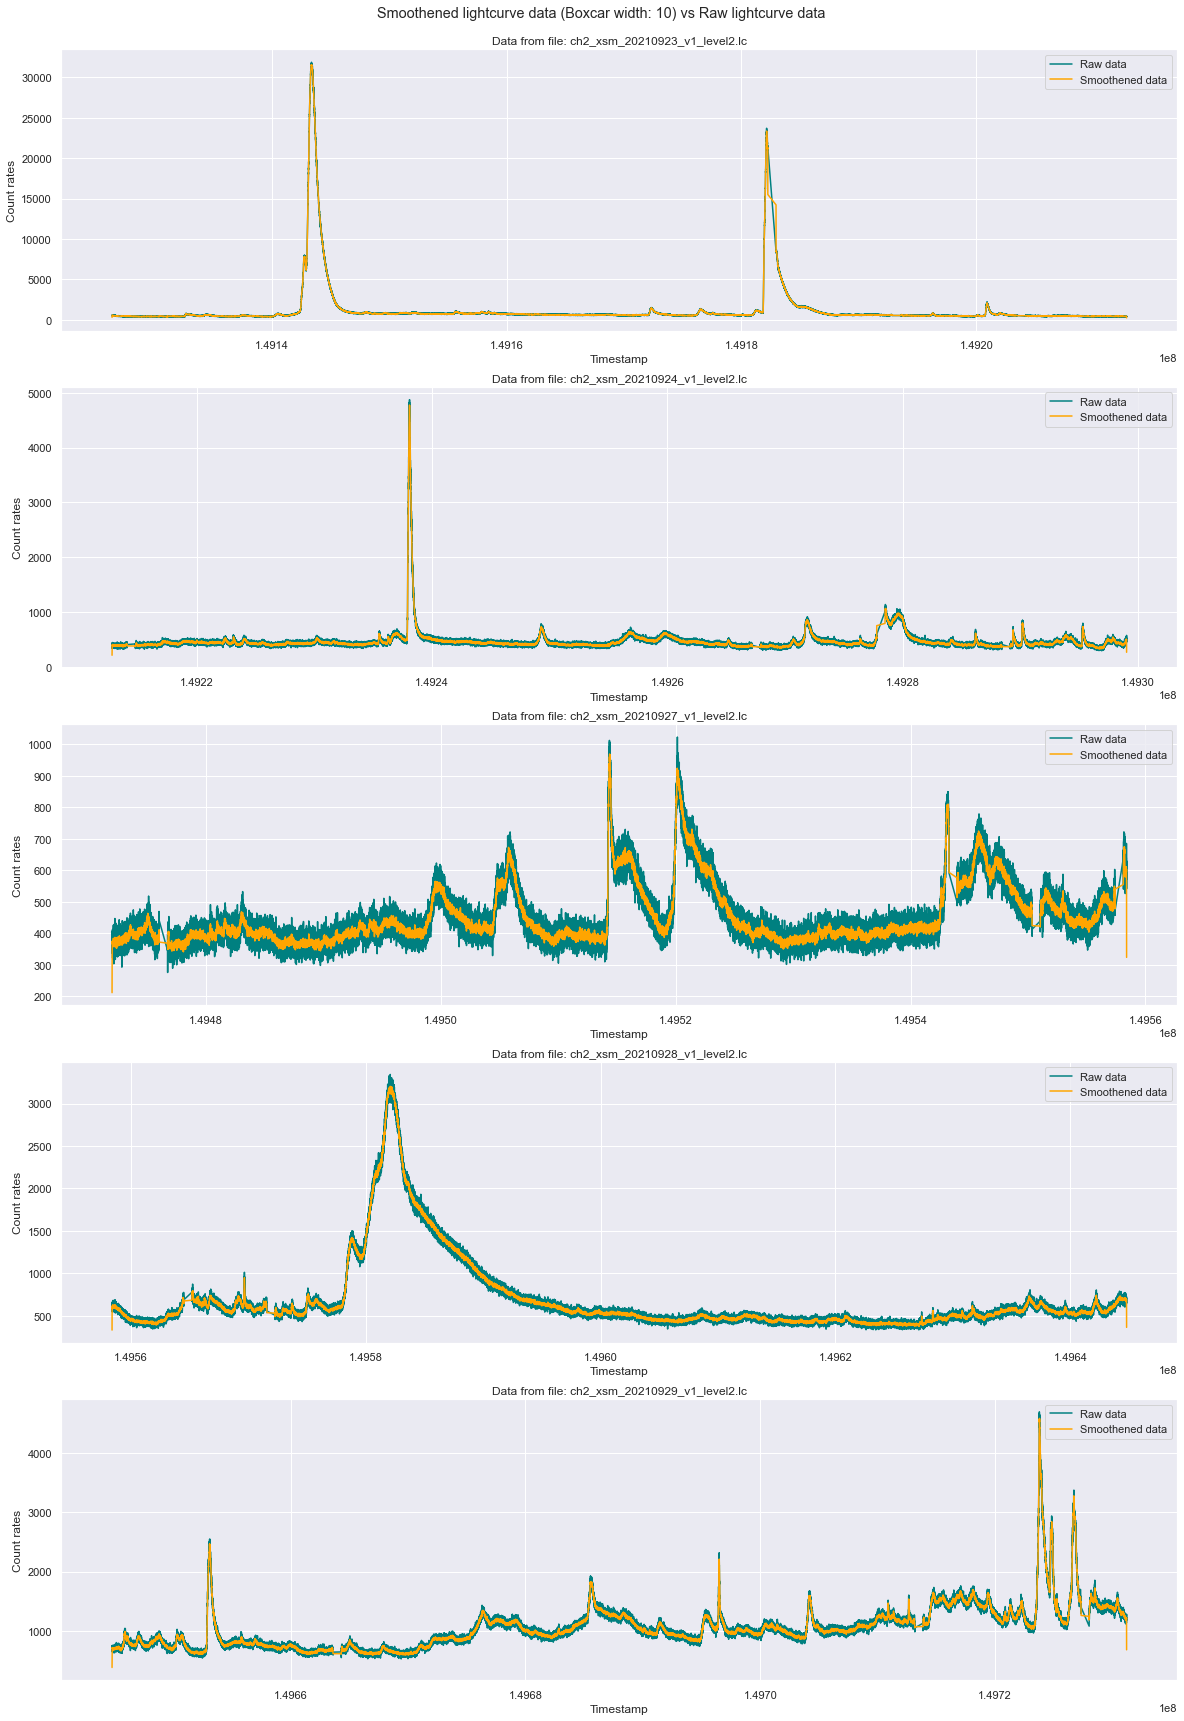

In [3]:
fig, ax = plt.subplots(5, 1, figsize = (20, 30))
fig.suptitle(t = f"Smoothened lightcurve data (Boxcar width: {width}) vs Raw lightcurve data", y = 0.9)
for i in range(len(rates_lc)):
    ax[i].set_title(f"Data from file: {lc_arr[i][0].header['FILENAME']}")
    ax[i].set_xlabel("Timestamp")
    ax[i].set_ylabel("Count rates")
    sns.lineplot(ax = ax[i], x = time_lc[i], y = rates_lc[i], label = "Raw data", color = "teal")
    sns.lineplot(ax = ax[i], x = time_lc[i], y = rates_smooth[i], label = "Smoothened data", color = "orange")
    ax[i].legend()

The boxcar filter smoothens out the noisy count rates quite a lot, especially in the third file data.

# Part 2
Re-binning the light curve

#### 2.1) Implement a method to rebin the histogram with a different timestep. Experiment on different time bins from a range of ~20 to ~200. Pick a few values (say 5) in this range and plot the lightcurve

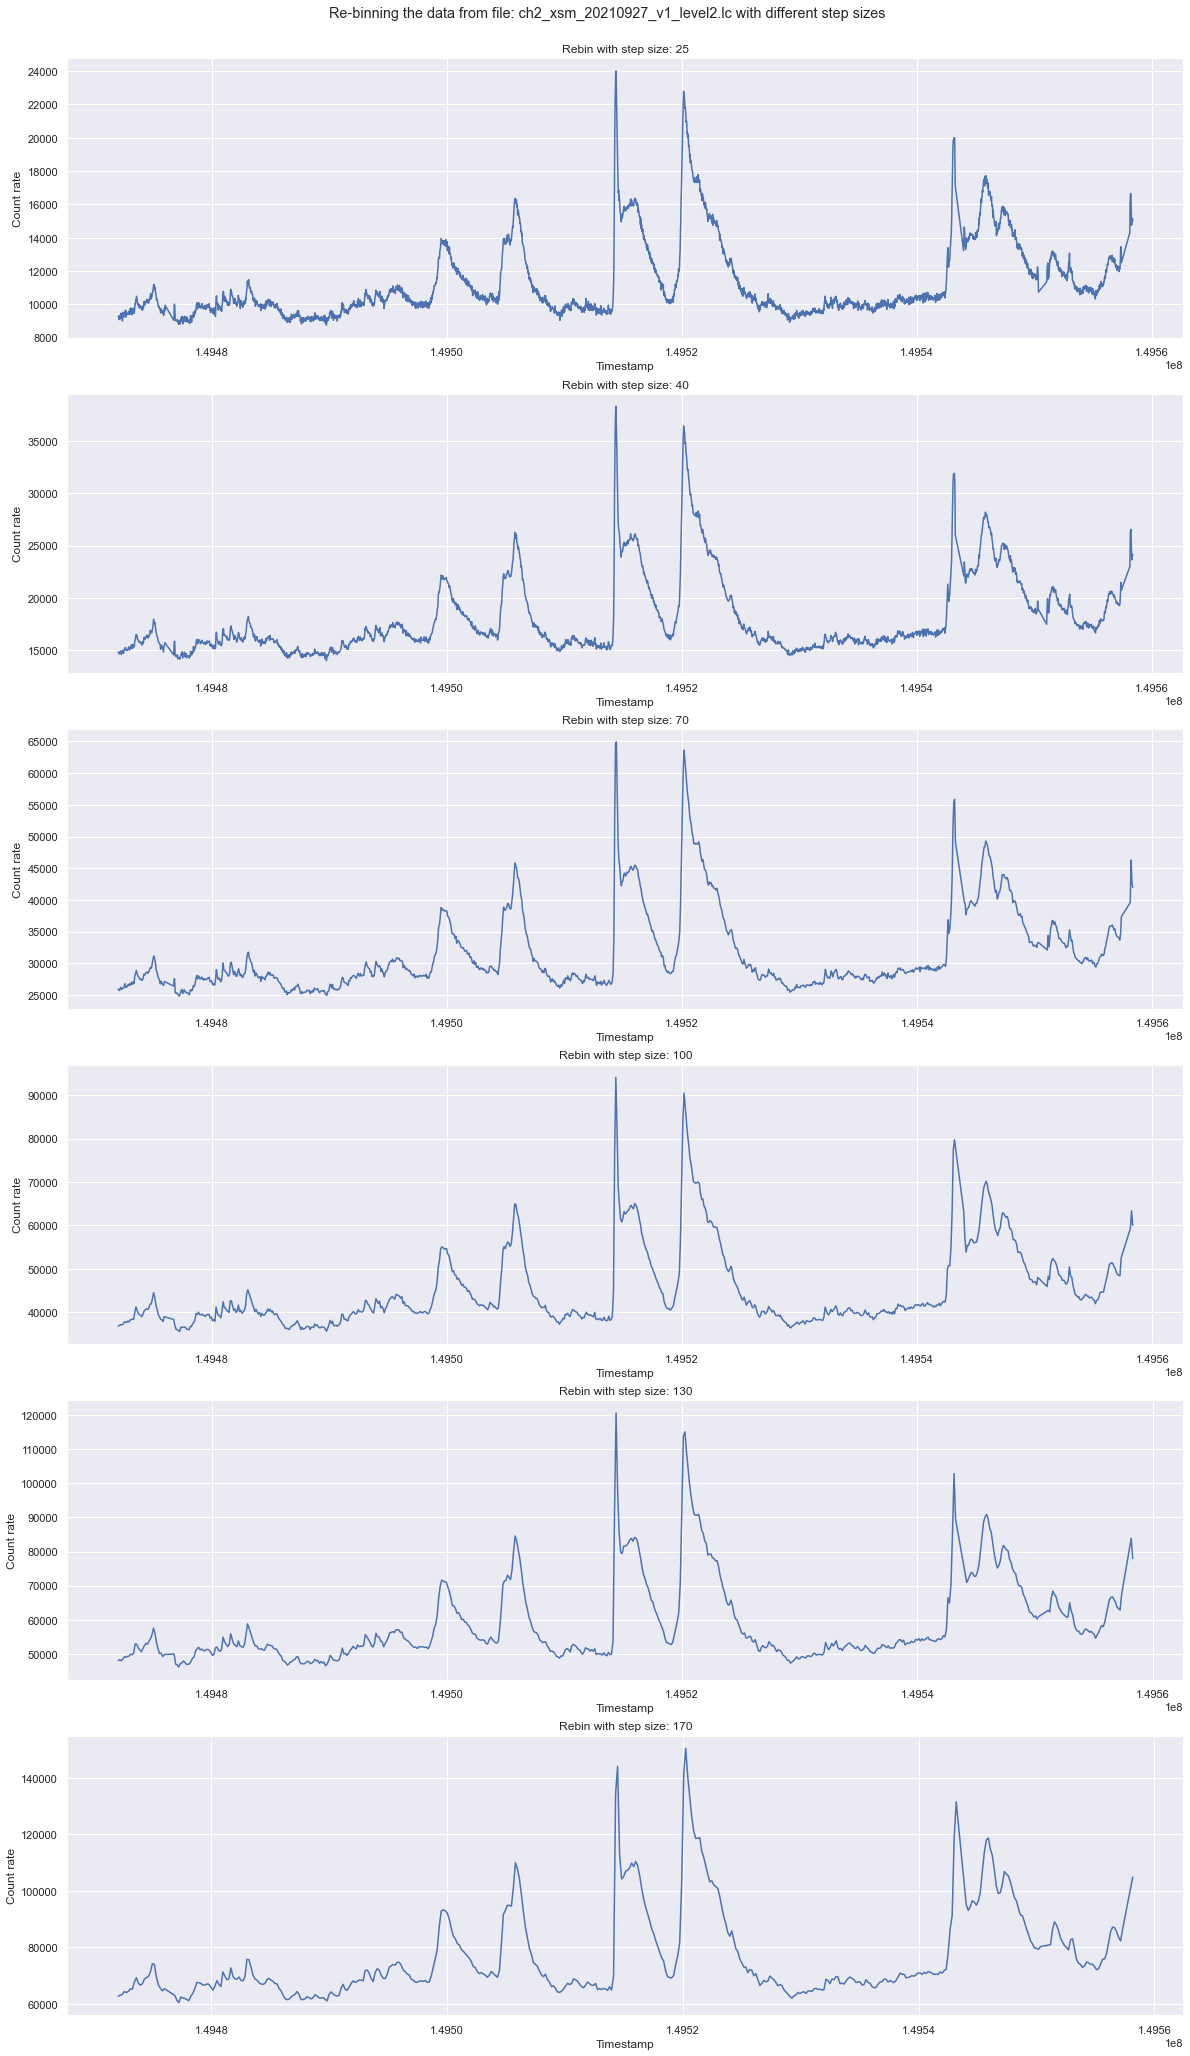

In [4]:
# Function to re-bin the histogram 
def rebin(rates, time, bin_length):
    rates_rebin = []
    time_rebin = []
    for i in range(len(rates)//bin_length):
        rates_rebin.append(np.sum(rates[bin_length*i:bin_length*(i+1)]))
        time_rebin.append(time[bin_length*i + bin_length//2])
    return (rates_rebin, time_rebin)

# Plot the re-binned histogram for a number of different steps
rebin_lengths = [25,40, 70, 100, 130, 170]
steps_no = len(rebin_lengths)
fig, ax = plt.subplots(steps_no, 1, figsize = (20, 6*steps_no))
fig.suptitle(t = f"Re-binning the data from file: {lc_arr[2][0].header['FILENAME']} with different step sizes", y = 0.9)
for l in range(steps_no):   
    r_rebin, t_rebin = rebin(rates_lc[2], time_lc[2], rebin_lengths[l])
    ax[l].set_title(f"Rebin with step size: {rebin_lengths[l]}")
    ax[l].set_xlabel("Timestamp")
    ax[l].set_ylabel("Count rate")
    sns.lineplot(ax = ax[l], x = t_rebin, y = r_rebin)

Re-binning the histograms has a smoothening effect as well. However there is one obvious disadvantage, the amplitude of the re-binned data blows up with respect to the original data.

# Part 3
A better N-sigma algorithm

#### 3.1) Calculate the mean and standard deviation of the count rate for the entire binned smoothened lightcurve and plot the mean + std dev as a horizontal line in the lightcurve

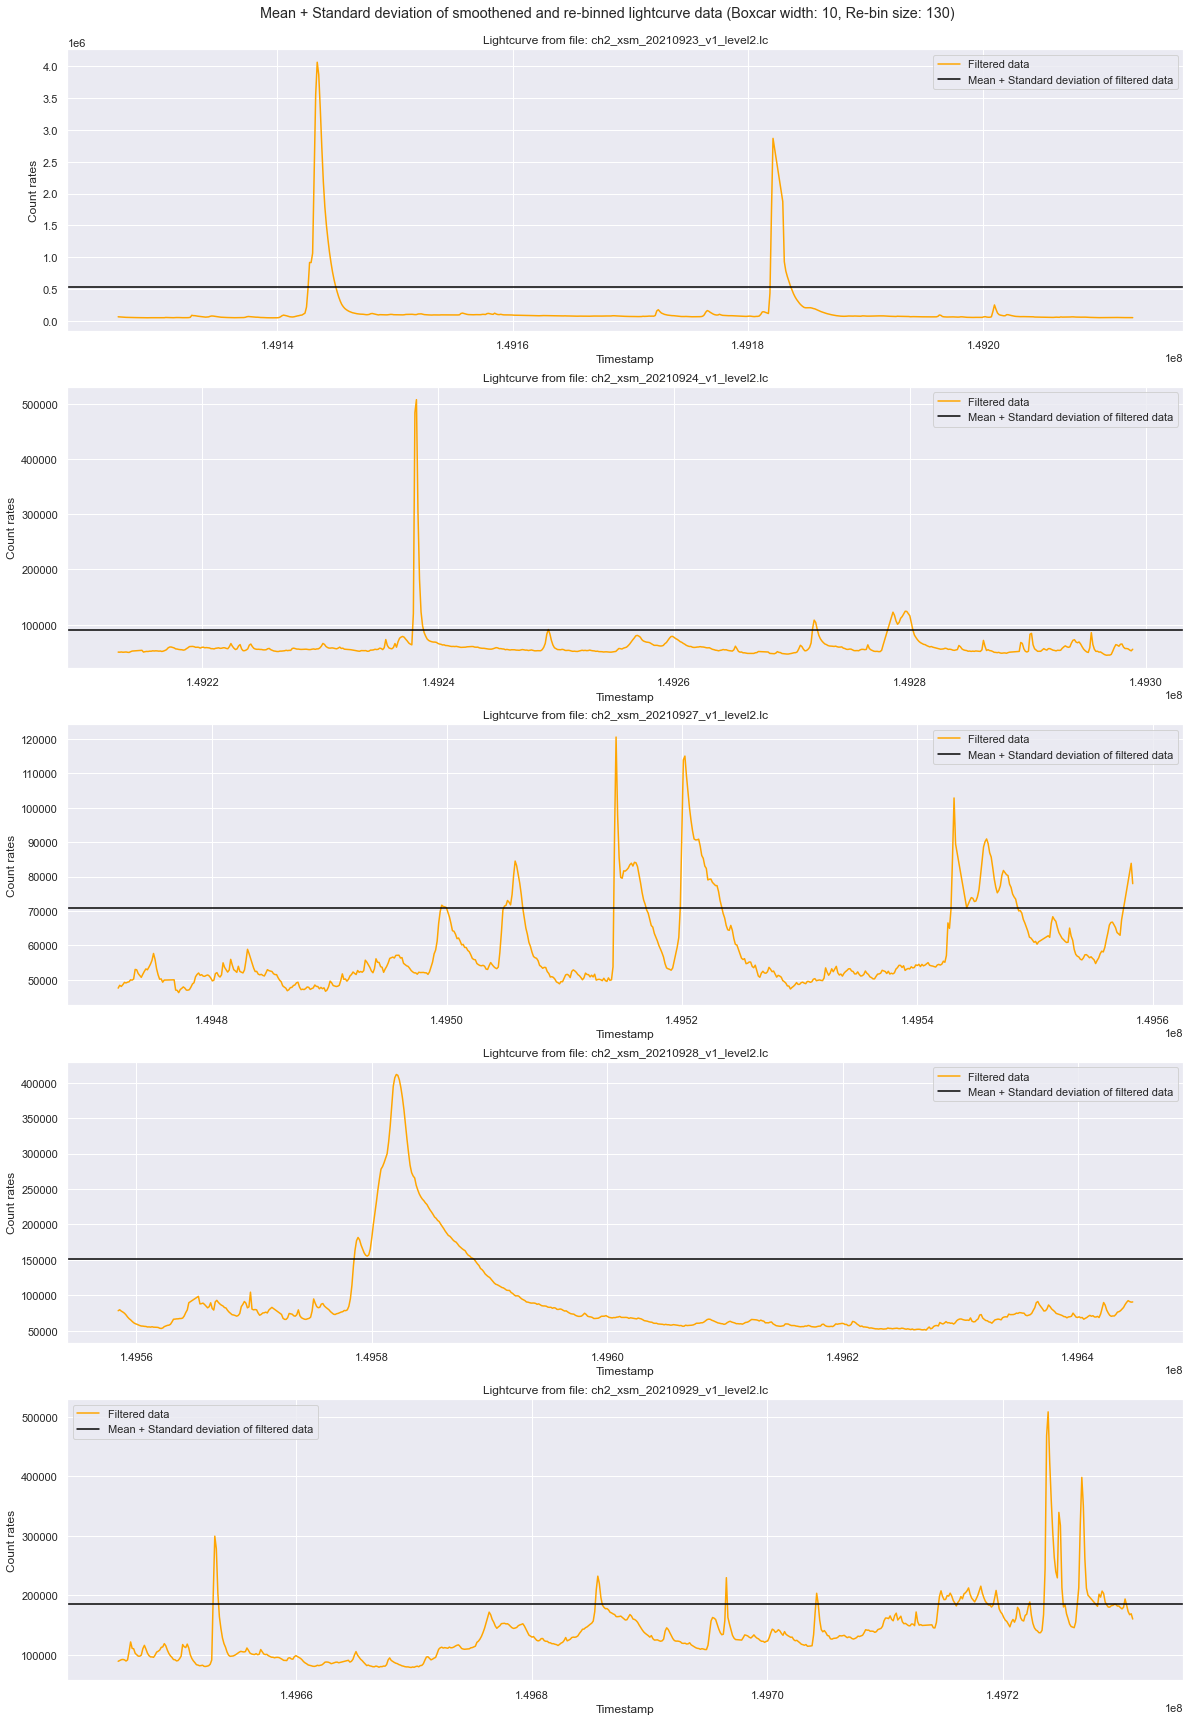

In [5]:
# Smoothen and re-bin all the five lightcurves with the following parameters
width = 10
rebin_length = 130
filtered_lc = []
for i in range(len(rates_lc)): 
    box_lc = convolve(rates_lc[i], Box1DKernel(width))
    filtered_lc.append(rebin(box_lc, time_lc[i], rebin_length))

# Calculate and plot mean + std dev. as a horizontal line
fig, ax = plt.subplots(5, 1, figsize = (20, 30))
fig.suptitle(t = f"Mean + Standard deviation of smoothened and re-binned lightcurve data (Boxcar width: {width}, Re-bin size: {rebin_length})", y = 0.9)
for flc_idx in range(len(filtered_lc)):
    flc = filtered_lc[flc_idx]
    mean = np.mean(flc[0])
    std = np.std(flc[0])
    ax[flc_idx].set_title(f"Lightcurve from file: {lc_arr[flc_idx][0].header['FILENAME']}")
    ax[flc_idx].set_xlabel("Timestamp")
    ax[flc_idx].set_ylabel("Count rates")
    sns.lineplot(ax = ax[flc_idx], x = flc[1], y = flc[0], label = "Filtered data", color = "orange")
    ax[flc_idx].axhline(y = mean+std, label = "Mean + Standard deviation of filtered data", color = "black")
    ax[flc_idx].legend()

#### 3.2) Is it correctly picking out flares from the lightcurve? How are the start and stop times you get here?

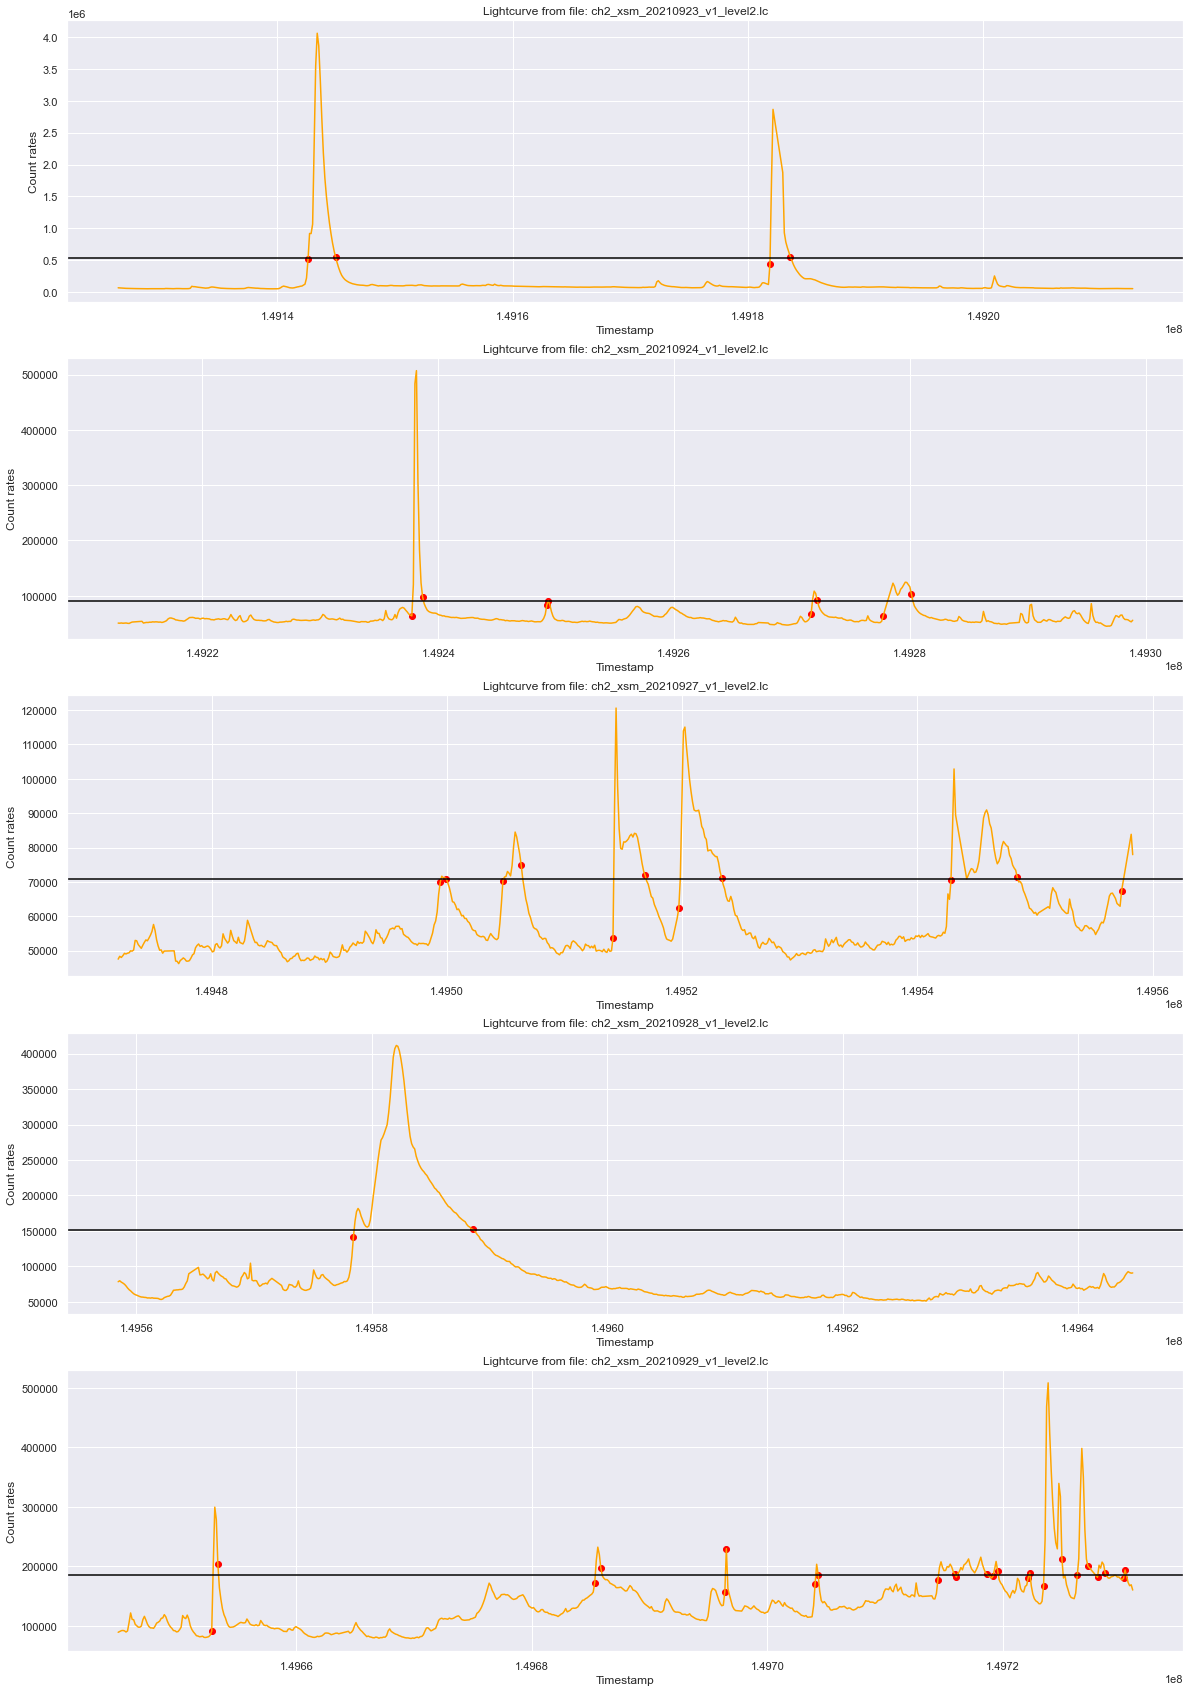

In [6]:
def find_intersect(f, g):
    # returns intersection points of the functions f and g assuming identical index arrays
    return np.argwhere(np.diff(np.sign(f - g))).flatten()

# Find intersection points of curves with the (mean + std) dev horizontal line
fig, ax = plt.subplots(5, 1, figsize = (20, 30))
for flc_idx in range(len(filtered_lc)):
    flc = filtered_lc[flc_idx]
    mean = np.mean(flc[0])
    std = np.std(flc[0])
    thresh = mean + std
    intersect = find_intersect(flc[0], thresh)
    sns.lineplot(ax = ax[flc_idx], x = flc[1], y = flc[0], color = "orange")
    ax[flc_idx].axhline(y = thresh, color = "black")
    ax[flc_idx].scatter(np.take(flc[1], intersect), np.take(flc[0], intersect), color = "red")
    ax[flc_idx].set_title(f"Lightcurve from file: {lc_arr[flc_idx][0].header['FILENAME']}")
    ax[flc_idx].set_xlabel("Timestamp")
    ax[flc_idx].set_ylabel("Count rates")

The start and stop times do not correspond to the actual start and stop times of the solar flares recorded. In the last three lightcurves, the start and stop times seem to be all over the place.

The give method of finding intersections of two graphs does not give the actual intersection point as well, however that can be improved with some linear extrapolation.

#### 3.3) Mask all the points above this threshold and set them to the value of the threshold, i.e set all points that have a count rate above this cutoff to the cutoff value. Plot this modified lightcurve

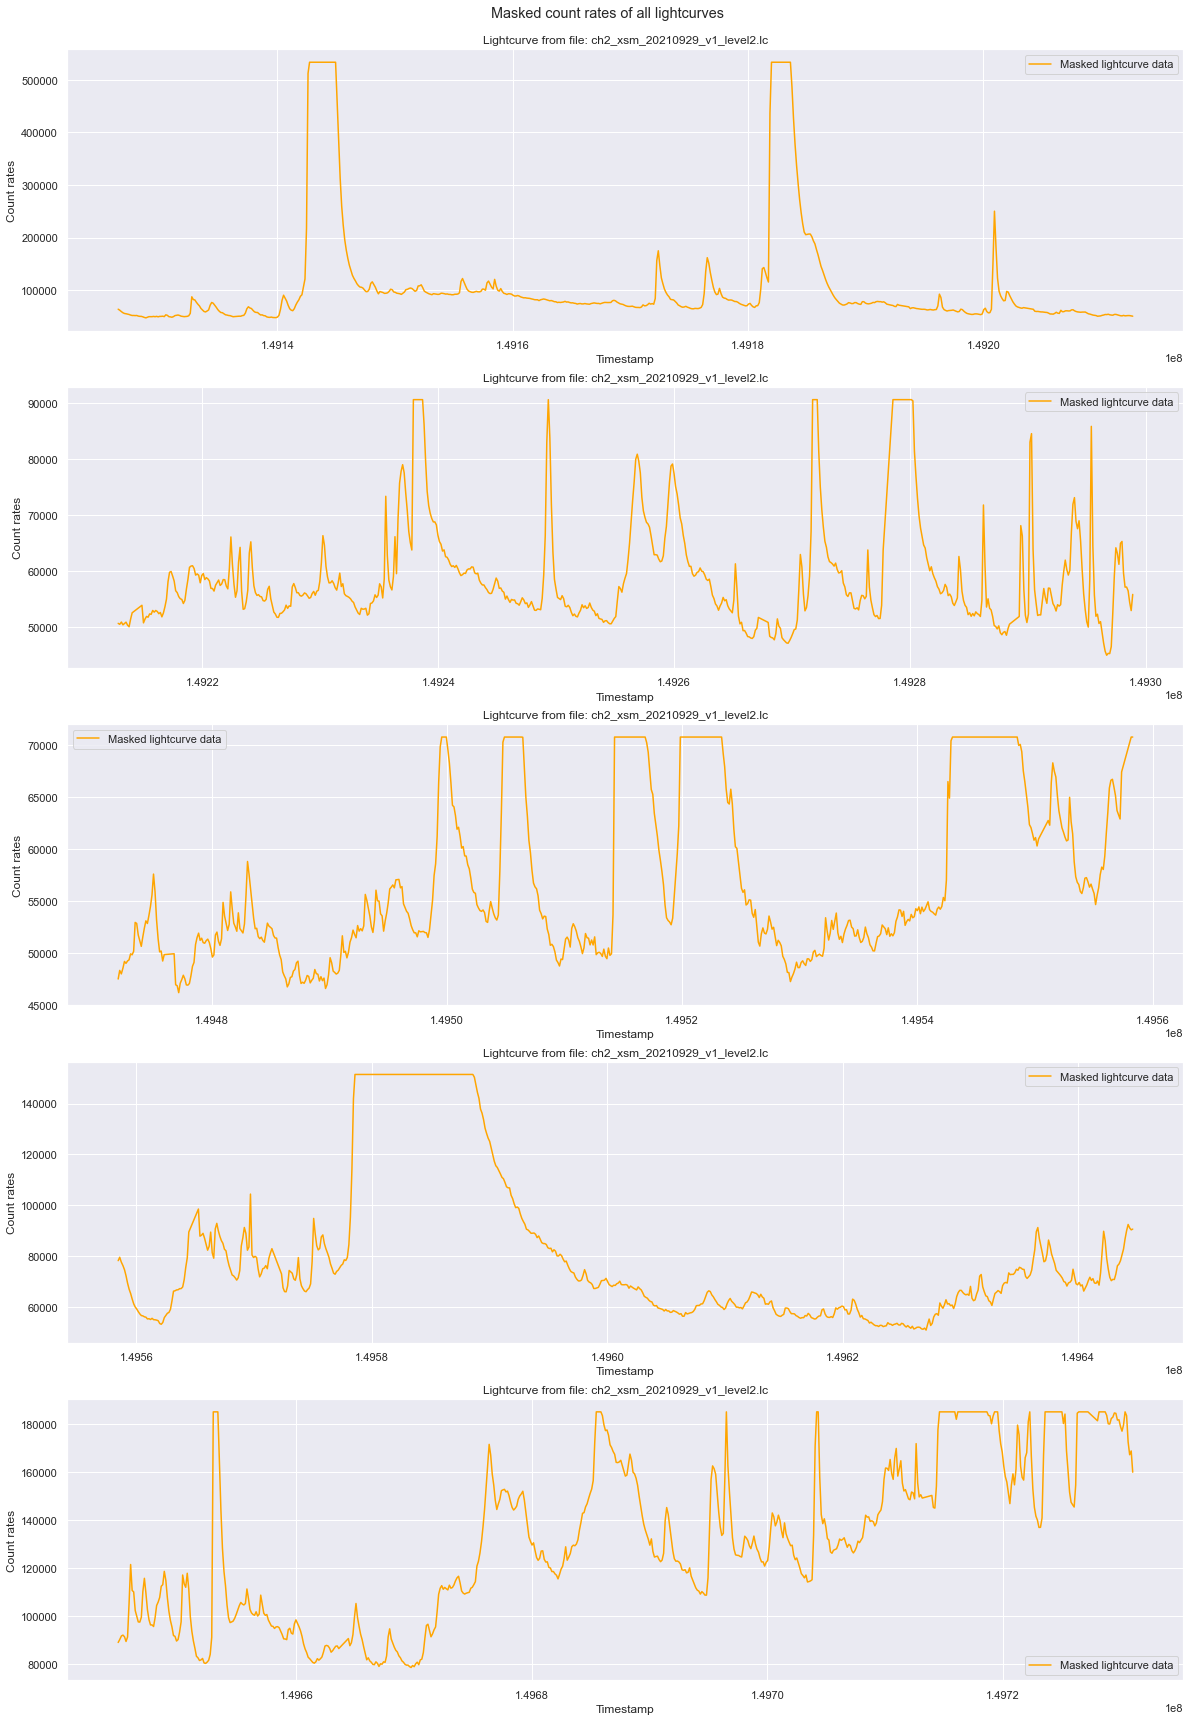

In [7]:
# Mask all points above threshold
masked_lc = []
for flc in filtered_lc:
    thresh = np.mean(flc[0]) + np.std(flc[0])
    m_counts = [x if x <= thresh else thresh for x in flc[0]] #masked counts
    entry = (m_counts, flc[1])
    masked_lc.append(entry)

# Plot the modified lightcurves
fig, ax = plt.subplots(5, 1, figsize = (20, 30))
fig.suptitle(t = "Masked count rates of all lightcurves", y = 0.9)
for mlc_idx in range(len(masked_lc)):
    mlc = masked_lc[mlc_idx]
    ax[mlc_idx].set_title(f"Lightcurve from file: {lc_arr[flc_idx][0].header['FILENAME']}")
    ax[mlc_idx].set_xlabel("Timestamp")
    ax[mlc_idx].set_ylabel("Count rates")
    sns.lineplot(ax = ax[mlc_idx], x = mlc[1], y = mlc[0], label = "Masked lightcurve data", color = "orange")
    ax[mlc_idx].legend()

The y limit of the figure may make it seem like there hasn't been much clipping, however when comparing amplitudes with the previous graph, we can see a significant decrease.

#### 3.4) Repeat the previous step on this new lightcurve thrice. Plot the final cutoff. Did the flare detection improve?

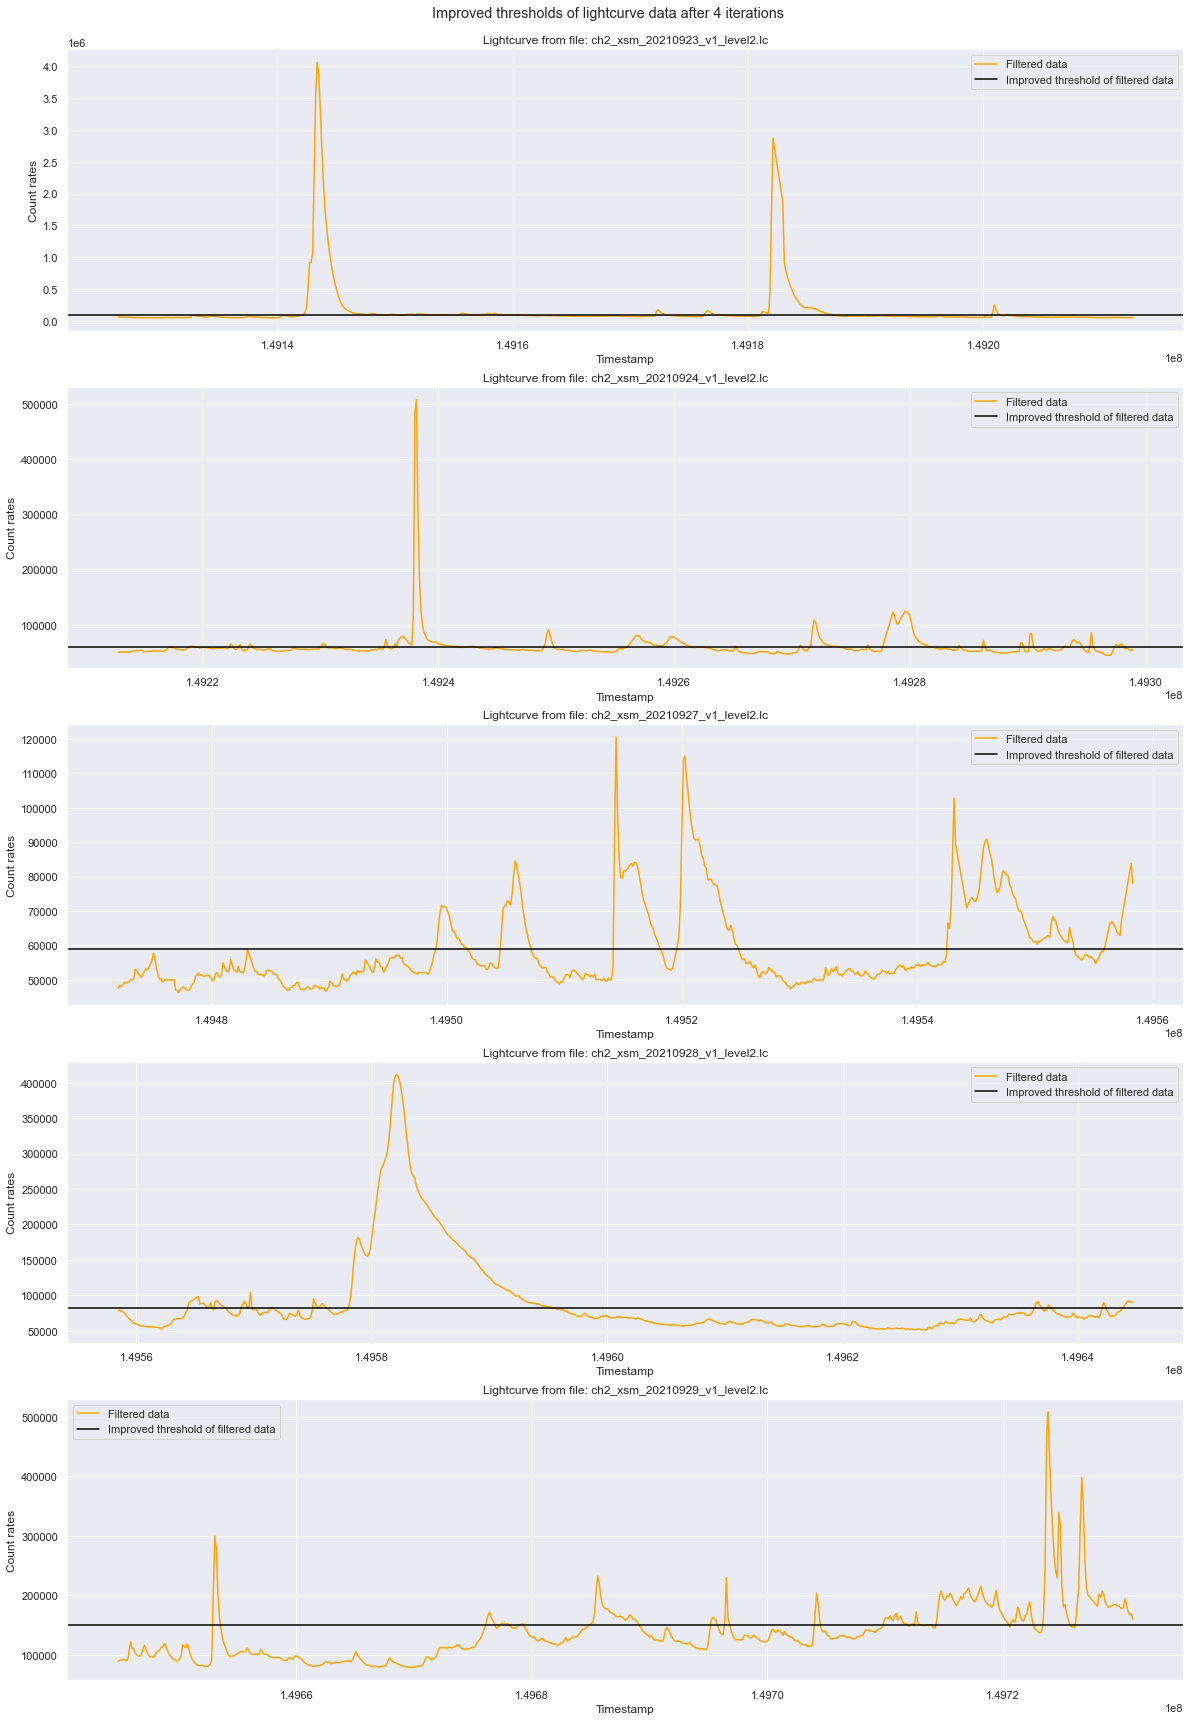

In [8]:
# Perform masking on all lightcurves thrice

# Return final threshold
thresh_n = []
for mlc in masked_lc:
    counts = mlc[0]
    time_n = mlc[1]
    for i in range (3):
        thresh = np.mean(counts) + np.std(counts)
        counts = [x if x <= thresh else thresh for x in counts]
    thresh_n.append(np.mean(counts) + np.std(counts)) # Final threshold

# PLot the final threshold with the other lightcurves
fig, ax = plt.subplots(5, 1, figsize = (20, 30))
fig.suptitle(t = "Improved thresholds of lightcurve data after 4 iterations", y = 0.9)
for flc_idx in range(len(filtered_lc)):
    flc = filtered_lc[flc_idx]
    ax[flc_idx].set_title(f"Lightcurve from file: {lc_arr[flc_idx][0].header['FILENAME']}")
    ax[flc_idx].set_xlabel("Timestamp")
    ax[flc_idx].set_ylabel("Count rates")
    sns.lineplot(ax = ax[flc_idx], x = flc[1], y = flc[0], label = "Filtered data", color = "orange")
    ax[flc_idx].axhline(y = thresh_n[flc_idx], label = "Improved threshold of filtered data", color = "black")
    ax[flc_idx].legend()

The flare detection has indeed improved drastically. We can filter out background noise from flare data better now.

#### 3.5) Tune the above method by replacing mean + std dev by mean + n*std dev. Pick a value of n that identifies flares well from all the lightcurves i.e one value of n that works best for all files together.

In this method, we will mask all points above mean + n\*std dev and then calculate new mean and standard deviation for furhter masking. This will be done three times and results will be compared for different values of n.

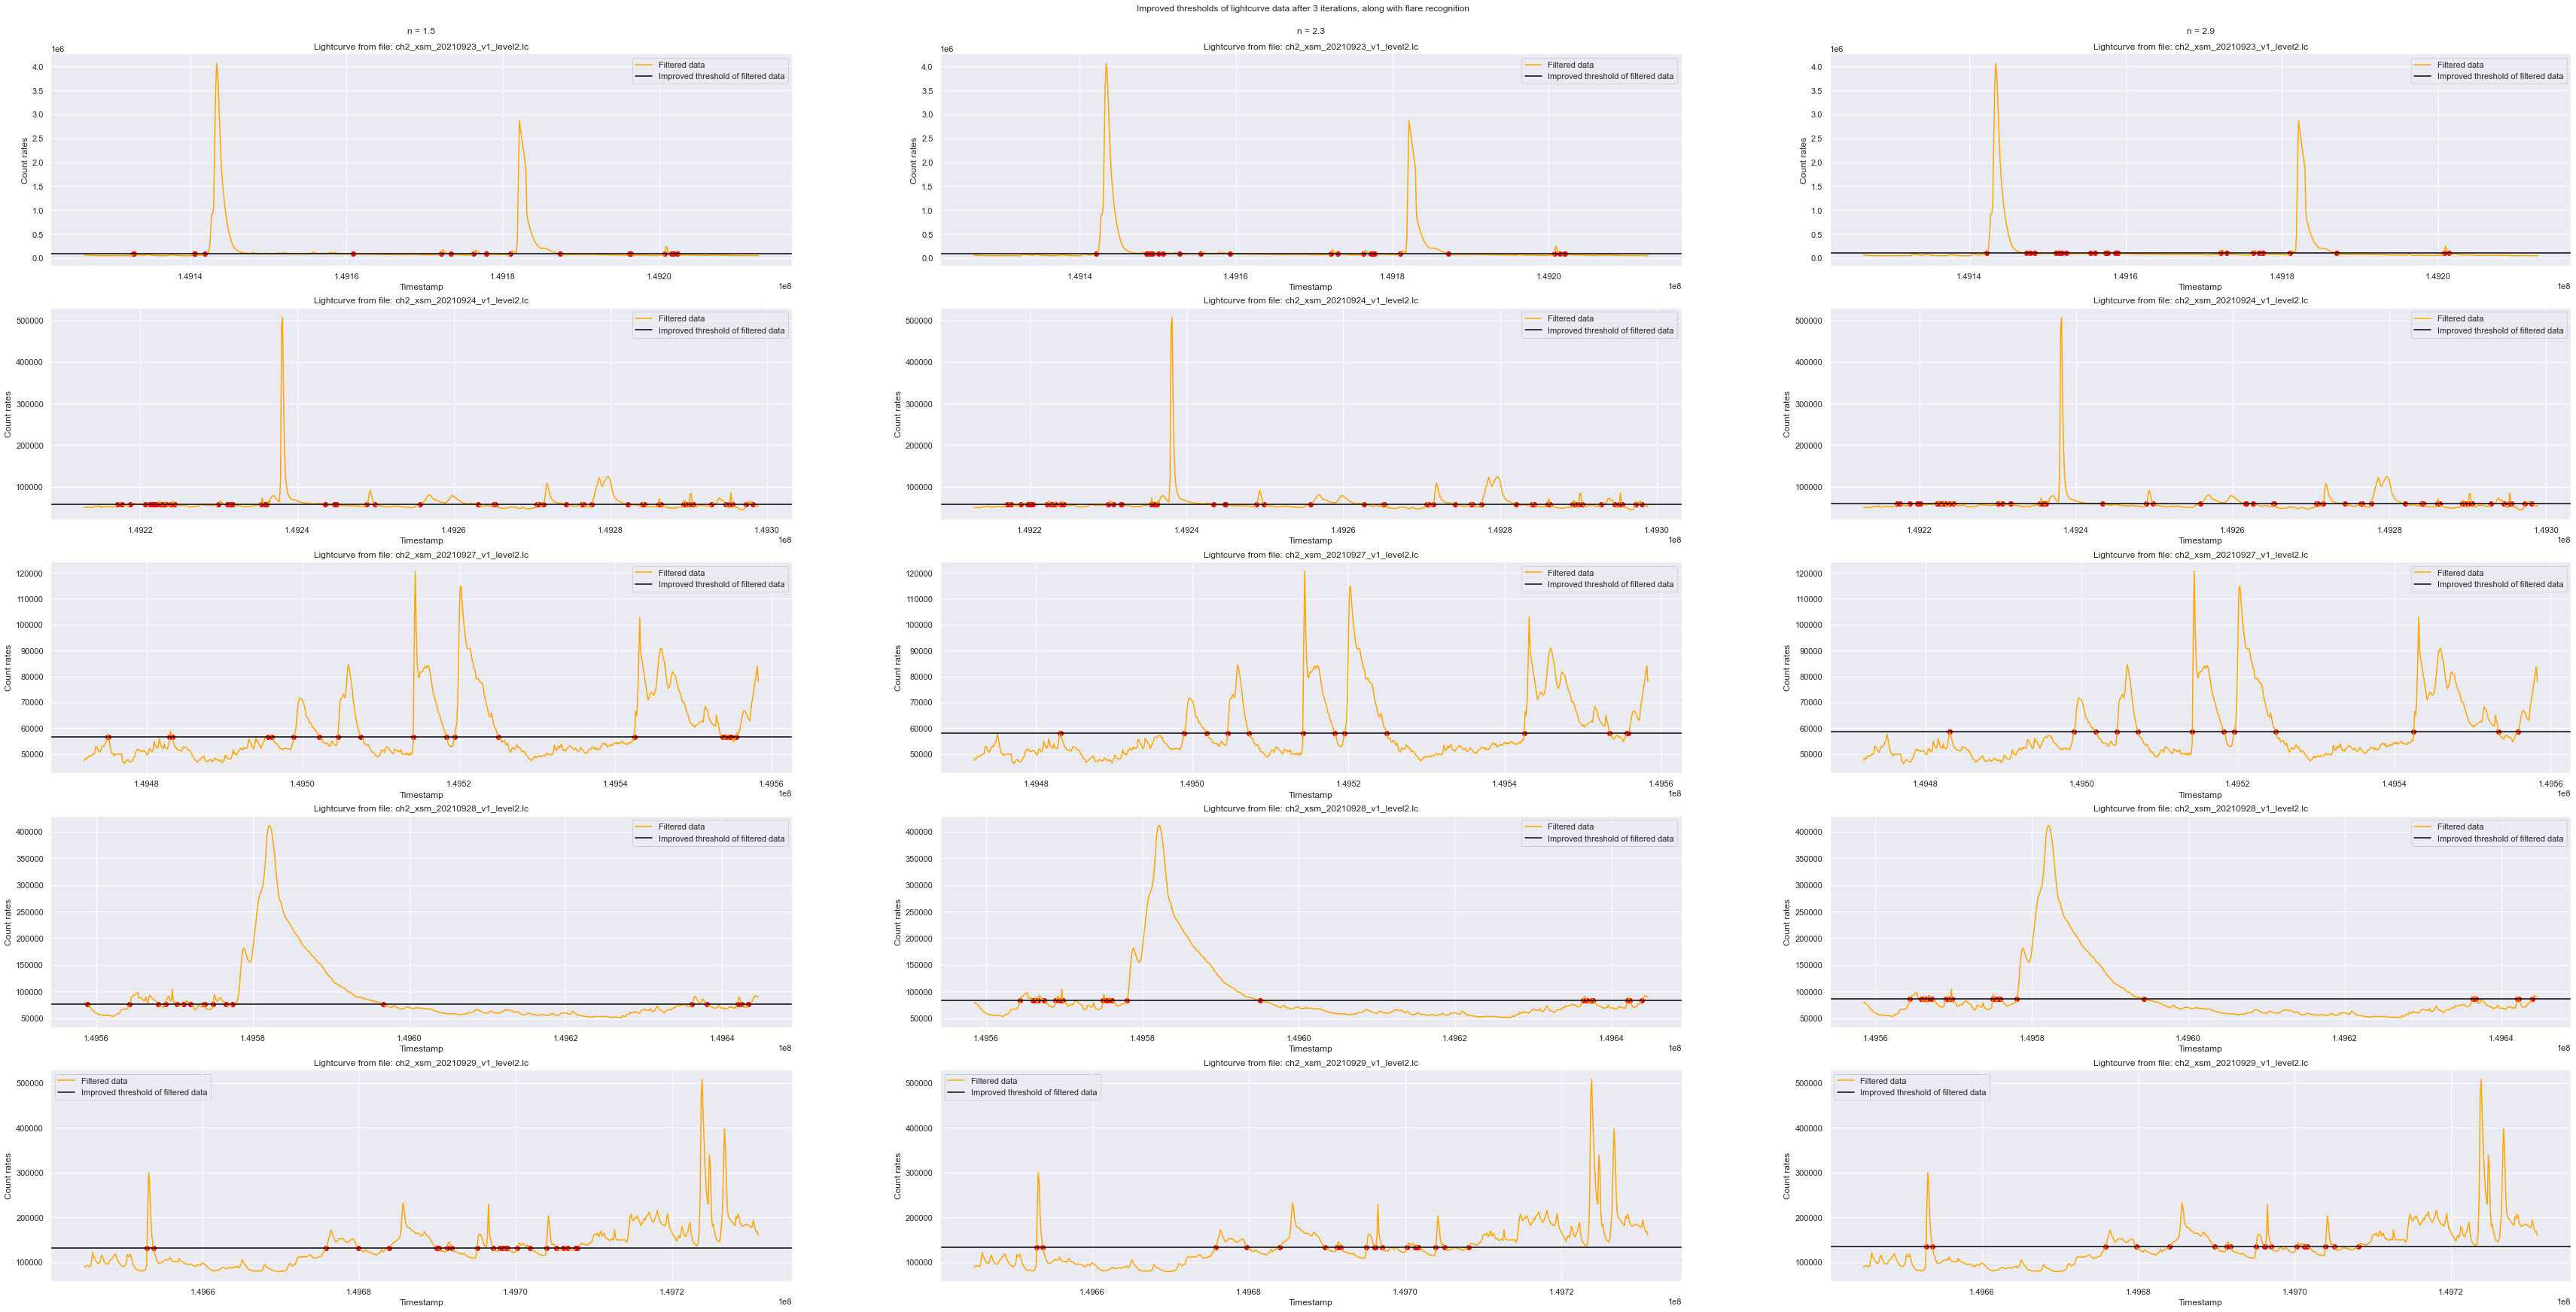

In [42]:
%matplotlib inline

n_arr = [1.5, 2.3, 2.9] # The parameter we want to optimise 
masked_lc = filtered_lc # Masked lightcurve counts. Initialise as un-masked filtered counts
m = 3 # No. of iterations

fig, ax = plt.subplots(5, len(n_arr), figsize = (20*len(n_arr), 30)) # 5x3 figure
fig.suptitle(t = f"Improved thresholds of lightcurve data after {m} iterations, along with flare recognition", y = 0.91, x = 0.51)

cols = [f"n = {i}" for i in n_arr] # Column headers
pad = 5
# Set column headers
for axes, col in zip(ax[0], cols):
    axes.annotate(col, xy=(0.5, 1.08), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')

for n_idx in range(len(n_arr)):
    thresh_n = [] # Stores thresholds of each lightcurve
    n = n_arr[n_idx]
    for mlc_idx in range(len(masked_lc)):
        mlc = masked_lc[mlc_idx][0]
        for i in range(m): # Start iteratively masking the lightcurve
            thresh = np.mean(mlc) + n*np.std(mlc)
            mlc = [min(i, thresh) for i in mlc]
        thresh_n.append(np.mean(mlc))
    
    # Plot filtered lightcurves with thresholds
    for flc_idx in range(len(filtered_lc)):
        thresh = thresh_n[flc_idx] # Threshold of current lc
        flc = filtered_lc[flc_idx]
        intersect = find_intersect(flc[0], thresh) # Find intersections with threshold line
        time_arr = []
        for idx in intersect: # perform some linear extrapolation for better placement of points
            t = abs(thresh - flc[0][idx])*(flc[1][idx+1] - flc[1][idx])/abs(flc[0][idx+1] - flc[0][idx]) + flc[1][idx]
            time_arr.append(t)
        
        #filter out pairs of points placed too close together (to remove false flares)
        #not done yet
        
        ax[flc_idx][n_idx].scatter(time_arr, [thresh for i in intersect], color = "red")
        ax[flc_idx][n_idx].set_title(f"Lightcurve from file: {lc_arr[flc_idx][0].header['FILENAME']}")
        ax[flc_idx][n_idx].set_xlabel("Timestamp")
        ax[flc_idx][n_idx].set_ylabel("Count rates")
        sns.lineplot(ax = ax[flc_idx][n_idx], x = flc[1], y = flc[0], label = "Filtered data", color = "orange")
        ax[flc_idx][n_idx].axhline(y = thresh, label = "Improved threshold of filtered data", color = "black")
        ax[flc_idx][n_idx].legend()

The value of $n = 2.3$ seems to work well with all lightcurves